In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import tensorflow as tf
import random
from random import randint
from random import shuffle
import librosa
import pickle

random.seed(42)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

In [4]:
# LOAD PROCESSED DATA
Training_Data_Load = pickle.load(open('Training_MMNIST.p', mode='rb'))
Validation_Data_Load = pickle.load(open('Validation_MMNIST.p', mode='rb'))

Training_Data, Training_Label = Training_Data_Load[1], Training_Data_Load[3]
Validation_Data, Validation_Label = Validation_Data_Load[1], Validation_Data_Load[3]

numberOfClasses = len(Training_Label[0])
print("training samples")
print(len(Training_Data))
print("validation samples")
print(len(Validation_Data))

training samples
20116
validation samples
3549


In [5]:
# TRAIN AN MLP TO CLASSIFY MNIST
import time
start_time = time.time()


reset_graph()

X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

# variable learning rate
aLearningRate = tf.placeholder(tf.float32, shape=[])
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0

W1  = tf.Variable(tf.random_uniform([784, 200],  minval=-0.2,maxval=0.2))
B1 =  tf.Variable(tf.random_normal([200], mean=0.1,stddev=.1))

W2 = tf.Variable(tf.random_uniform([200, 100],  minval=-0.2,maxval=0.2))
B2 = tf.Variable(tf.random_normal([100], mean=0.1,stddev=.1))

W3 = tf.Variable(tf.random_uniform([100, 60],  minval=-0.2,maxval=0.2))
B3 = tf.Variable(tf.random_normal([60], mean=0.1,stddev=.1))

W4 = tf.Variable(tf.random_uniform([60, 30],  minval=-0.2,maxval=0.2))
B4 = tf.Variable(tf.random_normal([30], mean=0.1,stddev=.1))

W5 = tf.Variable(tf.random_uniform([30, 10],  minval=-0.2,maxval=0.2))
B5 = tf.Variable(tf.random_normal([10], mean=0.1,stddev=.1))

Y1_hat = tf.nn.relu(tf.add(tf.matmul(X, W1), B1))
Y2_hat =  tf.nn.relu(tf.add(tf.matmul(Y1_hat, W2), B2))
Y3_hat =  tf.nn.relu(tf.add(tf.matmul(Y2_hat, W3), B3))
Y4_hat =  tf.nn.relu(tf.add(tf.matmul(Y3_hat, W4), B4))
Y_hat =  tf.nn.softmax(tf.add(tf.matmul(Y4_hat, W5), B5))

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_hat, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

optimizer = tf.train.AdamOptimizer(learning_rate=aLearningRate)
train_step = optimizer.minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_hat, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

import math 

validation_threshold = [0.7, 0.8, 0.9]
epoch_reached = []
earlystop_index = 0
earlystop_condition = validation_threshold[earlystop_index]

trainAcc = []
validAcc = []

n_epochs = 120
with tf.Session() as sess:
    sess.run(init)
    print("Start Training")
    # train
    for epoch in range(n_epochs):
        learning_rate = min_learning_rate+(max_learning_rate - min_learning_rate) * math.exp((-1*epoch)/2000)
        sess.run(train_step, feed_dict={X: Training_Data, Y: Training_Label, aLearningRate: learning_rate})
        
        
        tacc = sess.run(accuracy, feed_dict={X: Training_Data, Y: Training_Label})
        acc = sess.run(accuracy, feed_dict={X: Validation_Data, Y: Validation_Label})
        trainAcc.append(tacc)
        validAcc.append(acc)
        print("Accuracy at epoch",epoch,": %.4f" % (acc))    
        print('Epoch ' + str(epoch) + ' done')
        print("Condition is",earlystop_condition)
        if(acc > earlystop_condition or epoch == n_epochs):
            
            print("Threshold reached, feeding samples through for softmax prediction")
            epoch_reached.append(epoch)
            # Training output
            training_batch = sess.run(Y_hat, feed_dict={X: Training_Data})
            # Validation output
            validation_batch = sess.run(Y_hat, feed_dict={X: Validation_Data})
            
            pickle.dump((training_batch, Training_Label), open('IC_Training_' +str(earlystop_condition)+'.p', 'wb'))
            pickle.dump((validation_batch, Validation_Label), open('IC_Validation_'+str(earlystop_condition)+'.p', 'wb'))
            print("Done saving IC",earlystop_condition)
            
            # See if we should keep going, if there are more thresholds to meet
            if(earlystop_index < len(validation_threshold)-1):
                # keep going, reset condition
                earlystop_index += 1
                earlystop_condition = validation_threshold[earlystop_index]
                print("Next condition:",earlystop_condition)
            else:
                print("All conditions saved")
                print("Saved on last epoch")
                break
    print("Training done")
    print("Training done - took %s seconds" % (time.time() - start_time)) 


Start Training
Accuracy at epoch 0 : 0.2680
Epoch 0 done
Condition is 0.7
Accuracy at epoch 1 : 0.3812
Epoch 1 done
Condition is 0.7
Accuracy at epoch 2 : 0.4370
Epoch 2 done
Condition is 0.7
Accuracy at epoch 3 : 0.5024
Epoch 3 done
Condition is 0.7
Accuracy at epoch 4 : 0.4993
Epoch 4 done
Condition is 0.7
Accuracy at epoch 5 : 0.5689
Epoch 5 done
Condition is 0.7
Accuracy at epoch 6 : 0.5765
Epoch 6 done
Condition is 0.7
Accuracy at epoch 7 : 0.6300
Epoch 7 done
Condition is 0.7
Accuracy at epoch 8 : 0.6236
Epoch 8 done
Condition is 0.7
Accuracy at epoch 9 : 0.6706
Epoch 9 done
Condition is 0.7
Accuracy at epoch 10 : 0.6743
Epoch 10 done
Condition is 0.7
Accuracy at epoch 11 : 0.6886
Epoch 11 done
Condition is 0.7
Accuracy at epoch 12 : 0.6909
Epoch 12 done
Condition is 0.7
Accuracy at epoch 13 : 0.6994
Epoch 13 done
Condition is 0.7
Accuracy at epoch 14 : 0.7146
Epoch 14 done
Condition is 0.7
Threshold reached, feeding samples through for softmax prediction
Done saving IC 0.7
Next 

In [6]:


def confirmAccuracy(per):
    print("Accuracy of IC",per)
    
    td, tl = pickle.load(open('IC_Training_'+per+'.p', mode='rb'))
    vd, vl = pickle.load(open('IC_Validation_'+per+'.p', mode='rb'))
    
    tcnt = 0
    for i in range(len(td)):
        if(np.argmax(td[i]) == np.argmax(tl[i])):
            tcnt += 1
    print("trainAcc",tcnt/len(td))
    vcnt = 0
    for i in range(len(vd)):
        if(np.argmax(vd[i]) == np.argmax(vl[i])):
            vcnt += 1
    print("validAcc",vcnt/len(vd))
    print("")

    
confirmAccuracy("0.7")    
confirmAccuracy("0.8")    
confirmAccuracy("0.9")

Accuracy of IC 0.7
trainAcc 0.7082919069397494
validAcc 0.7145674837982531

Accuracy of IC 0.8
trainAcc 0.7965798369457149
validAcc 0.8016342631727247

Accuracy of IC 0.9
trainAcc 0.9310996221912905
validAcc 0.9120879120879121



In [7]:
epoch_reached

[14, 21, 64]

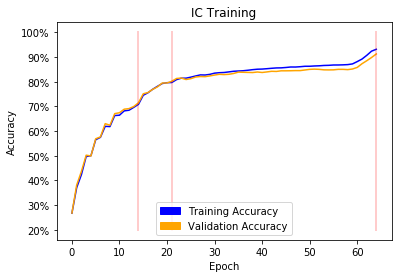

In [8]:
plt.figure(2)
plt.plot(trainAcc, color='b', alpha=1)
plt.plot(validAcc, color='orange', alpha=1)

for epoch in epoch_reached:
    plt.plot([epoch, epoch], [1, 0.2], 'k-', color='r', alpha=0.2, lw=2)

plt.title('IC Training')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
blue = mpatches.Patch(color='b', label='Training Accuracy')
orange = mpatches.Patch(color='orange', label='Validation Accuracy')
plt.legend(handles=[blue,orange], loc='lower center')
plt.show()